In [1]:
%config InlineBackend.figure_format = 'svg'
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import gamma

In [2]:
# true probability density function
def pdf(x):
    p1 = 0.25
    p2 = 1 - p1
    m1, m2 = 0.25, 0.75
    s1, s2 = 0.06, 0.1
    return p1 * norm.pdf(x, loc=m1, scale=s1) + p2 * norm.pdf(x, loc=m2, scale=s2)

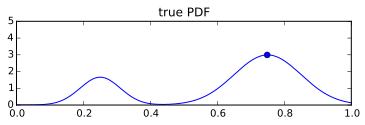

x_max: 0.748743718593, y_max: 2.99183100188


In [3]:
x = np.linspace(0, 1, 200)
plt.plot(x, pdf(x))
plt.ylim(0, 5)
plt.gca().set_aspect(0.05)
plt.title('true PDF')

x_max = x[np.argmax(pdf(x))]
y_max = pdf(x_max)
plt.plot(x_max, y_max, 'bo')
plt.show()
print 'x_max: {}, y_max: {}'.format(x_max, y_max)

In [4]:
# generate training data by Acceptance-Rejection Method
def genData(pdf, xmin, xmax, ymin, ymax, n):
    data = []
    for i in xrange(n):
        while True:
            x = np.random.uniform(xmin, xmax)
            if np.random.uniform(ymin, ymax) < pdf(x):
                data.append(x)
                break
    return data

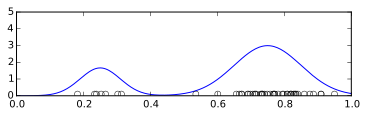

In [5]:
XMIN, XMAX = 0, 1
NDATA = 50
trnData = genData(pdf, XMIN, XMAX, 0, y_max+0.01, 50)

x = np.linspace(0, 1, 200)
plt.plot(x, pdf(x), 'b-')
plt.plot(trnData, np.zeros(NDATA)+0.1, 'o', mec='k', mfc='none')
plt.ylim(0, 5)
plt.gca().set_aspect(0.05)

## ヒストグラム法

In [6]:
def pltHist(data, delta, xmin, xmax):
    bins = int((xmax - xmin) / delta)
    plt.hist(data, bins, range=(xmin, xmax), normed=True, histtype='bar', color='w')
    plt.text(0.05, 3.5, r'$\Delta\ =\ {0:3.2f}$'.format(delta), fontsize=15, backgroundcolor='w')
    plt.ylim(0, 5)

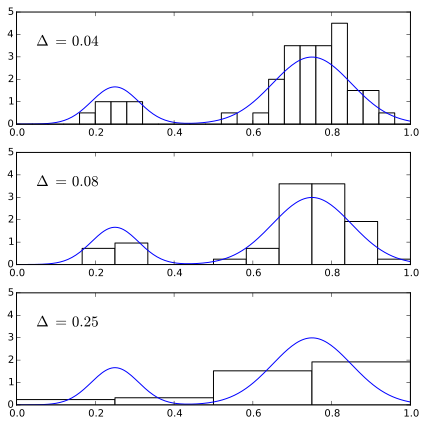

In [7]:
x = np.linspace(0, 1, 200)

plt.figure(figsize=(6, 6))
plt.subplot(311)
pltHist(trnData, 0.04, 0, 1)
plt.plot(x, pdf(x))

plt.subplot(312)
pltHist(trnData, 0.08, 0, 1)
plt.plot(x, pdf(x))

plt.subplot(313)
pltHist(trnData, 0.25, 0, 1)
plt.plot(x, pdf(x))

plt.tight_layout()

## 2.5.1 カーネル密度推定法

In [8]:
@np.vectorize
def parzenWindow(x):
    if abs(x) <= 1/2:
        return 1
    else:
        return 0
    
def gaussWindow(x):
    return 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x ** 2)

In [9]:
def kernelPDF(x, data, kernel, h, N, D=1):
    return 1/N * sum(kernel((x - xn) / h) for xn in data) / h**D

In [10]:
def pltKernel(data, kernel, h):
    x = np.linspace(XMIN, XMAX, 200)
    plt.plot(x, kernelPDF(x, data, kernel, h, NDATA, 1), 'k-')
    plt.text(0.05, 3.5, r'$h\ =\ {0:1f}$'.format(h), fontsize=15, backgroundcolor='w')
    plt.ylim(0, 5)
    
def pltKernels(data, kernel):
    x = np.linspace(XMIN, XMAX, 200)
    plt.figure(figsize=(6, 6))
    
    plt.subplot(311)
    pltKernel(data, kernel, 0.005)
    plt.plot(x, pdf(x))

    plt.subplot(312)
    pltKernel(data, kernel, 0.07)
    plt.plot(x, pdf(x))

    plt.subplot(313)
    pltKernel(data, kernel, 0.2)
    plt.plot(x, pdf(x))

    plt.tight_layout()

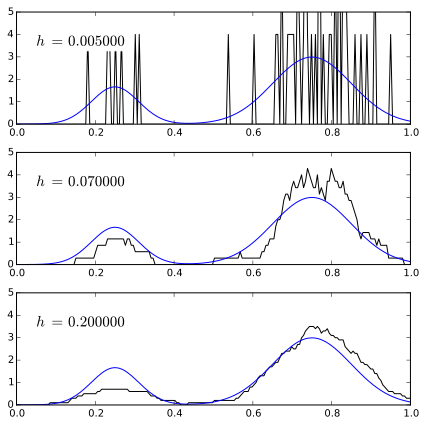

In [11]:
pltKernels(trnData, parzenWindow)

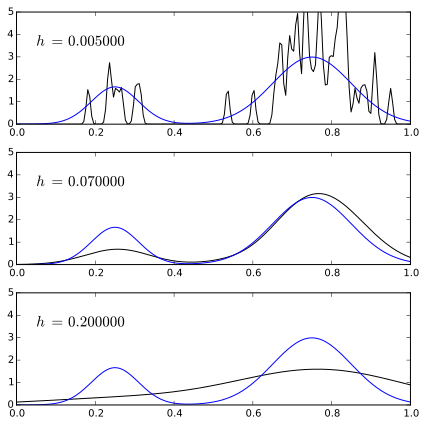

In [12]:
pltKernels(trnData, gaussWindow)

## 2.5.2 K近傍法

In [13]:
def nDimBallVolume(r, n):
    return 2 * np.pi ** (n/2) / (n * gamma(n/2)) * r ** n
# [nDimBallVolume(1, n) for n in range(1, 4)] => [2.0, np.pi, 4 * np.pi / 3]

def calV(x, data, K):
    r = sorted(np.absolute(np.array(data) - x))
    return nDimBallVolume(r[K-1], 1)    

def kNN(x, data, K):
    return [K / (len(data) * calV(y, data, K)) for y in x]

def pltKNN(x, data, K):
    plt.plot(x, kNN(x, data, K), 'k-')
    plt.text(0.05, 3.5, r'$K\ =\ {0:d}$'.format(K), fontsize=15, backgroundcolor='w')
    plt.ylim(0, 5)

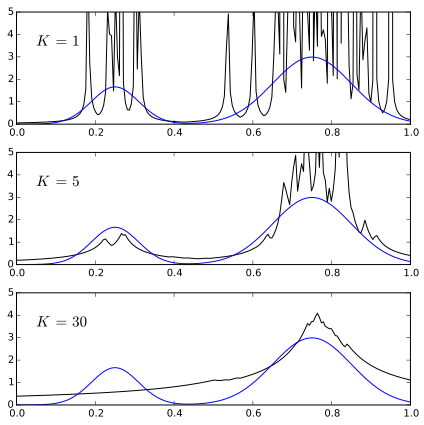

In [ ]:
x = np.linspace(0, 1, 200)
plt.figure(figsize=(6, 6))

plt.subplot(311)
pltKNN(x, trnData, 1)
plt.plot(x, pdf(x))


plt.subplot(312)
pltKNN(x, trnData, 5)
plt.plot(x, pdf(x))

plt.subplot(313)
pltKNN(x, trnData, 30)
plt.plot(x, pdf(x))

plt.tight_layout()

## 送油データのデータ点を、K近傍法で入力空間のクラスへの分割

In [ ]:
from sklearn import neighbors
from matplotlib.colors import ListedColormap

tranMeas = np.loadtxt('../../PRML_oilFlow/DataTrn.txt', dtype=float)
tranLabl = np.loadtxt('../../PRML_oilFlow/DataTrnLbls.txt', dtype=int)

K = 30
clf = neighbors.KNeighborsClassifier(K, weights='uniform')
clf.fit(tranMeas[:, 5:7], [np.argmax(x) for x in tranLabl])
x_min, x_max = tranMeas[:, 5].min() - 0.1, tranMeas[:, 5].max() + 0.1
y_min, y_max = tranMeas[:, 6].min() - 0.1, tranMeas[:, 6].max() + 0.1
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(9, 9))
plt.pcolormesh(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))

# LookIndex1について
tranMeas1Homo = tranMeas[:, 5][np.array(tranLabl[:, 0], dtype=bool)]
tranMeas1Annu = tranMeas[:, 5][np.array(tranLabl[:, 1], dtype=bool)]
tranMeas1Stra = tranMeas[:, 5][np.array(tranLabl[:, 2], dtype=bool)]

# LookIndex2について
tranMeas2Homo = tranMeas[:, 6][np.array(tranLabl[:, 0], dtype=bool)]
tranMeas2Annu = tranMeas[:, 6][np.array(tranLabl[:, 1], dtype=bool)]
tranMeas2Stra = tranMeas[:, 6][np.array(tranLabl[:, 2], dtype=bool)]

# Homo: 343, Annu: 316, Stra: 341
plotNum = 300

opt = {'linestyle': 'None', 'marker': 'o', 'ms': 7, 'mfc': 'None', 'mew': 1.5}
plt.plot(tranMeas1Homo[:plotNum], tranMeas2Homo[:plotNum], label='Homogenuos', mec='r', **opt)
plt.plot(tranMeas1Annu[:plotNum], tranMeas2Annu[:plotNum], label='Annular',    mec='g', **opt)
plt.plot(tranMeas1Stra[:plotNum], tranMeas2Stra[:plotNum], label='Stratified', mec='b', **opt)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()